### Plan
1. Implement "volume knob" -> adjust amplitude for all ranges
2. Implement for 2 frequency ranges

### References
1. https://stackoverflow.com/questions/24920346/filtering-a-wav-file-using-python
2. https://octovoid.com/2017/11/04/coding-a-parametric-equalizer-for-audio-applications/
3. https://stackoverflow.com/questions/54932976/audio-equalizer

[ 0  0 42 ...  4  4  2]


ValueError: n should be an integer

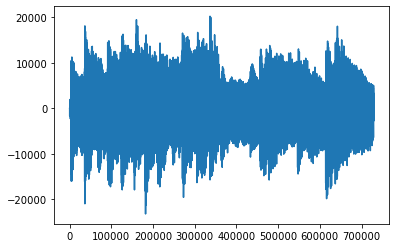

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import wave

def open_plot_file():

    file_path = './electric_guitar_sample.wav'

    audio_data = wave.open(file_path, 'r')

    audio_signal = audio_data.readframes(-1)
    audio_signal = np.frombuffer(audio_signal, dtype='int16')
    
    print(audio_signal)

    plt.figure(1)
    plt.plot(audio_signal)

    audio_fft = np.fft.fft(audio_signal)
    audio_freq = np.fft.fftfreq(len(audio_signal))
    
    print(audio_fft)
    
    plt.figure(2)
    plt.plot(audio_fft)
    
    Y    = np.fft.fft(audio_signal)
    freq = np.fft.fftfreq(len(audio_signal))

    plt.figure()
    plt.plot( freq, np.abs(Y) )
    plt.figure()
    plt.plot(freq, np.angle(Y) )
    plt.show()

def bandpass_filter(low_frequency, high_frequency, fs, num_taps = 101):
    pass

open_plot_file()

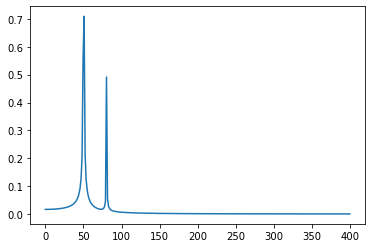

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()